<a href="https://colab.research.google.com/github/yaiza612/Big_data/blob/main/Consulting_project_hack_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SPARK_VERSION = '3.4.0'
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
os.environ["SPARK_VERSION"] = '3.4.0'
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = spark.read.options(header='True', inferSchema='True').csv('/content/drive/MyDrive/Colab_Notebooks/hack_data.csv')
df.registerTempTable('data')

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [6]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



Taking a look to the data to see how looks like.


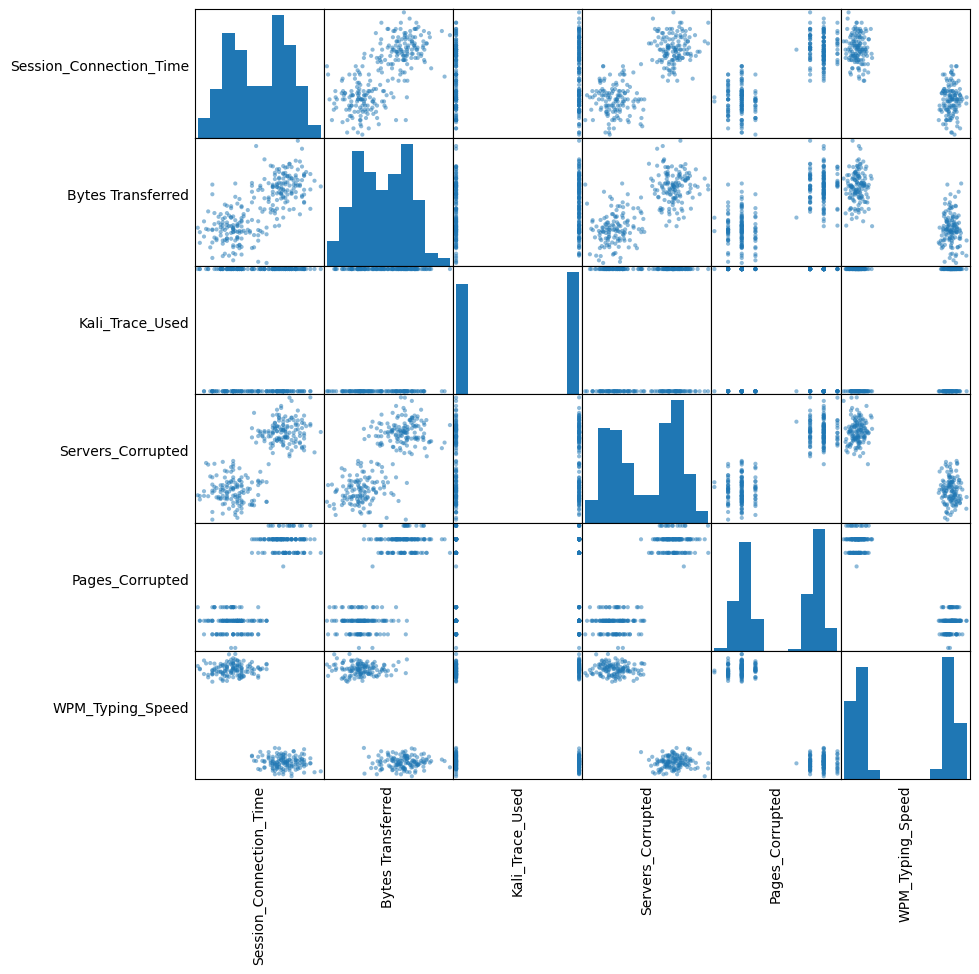

In [7]:
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

This method, the plotting is a method that you can not use with a dataframe of terabytes, nevertheless, you could take a random small portion of the data to do the same analysis, I just perform and see more or less the relation that exist between the different variables.
For the visualization, seems that there are only two groups and not three but 
we will scale the data, compute the silhouette score and check what clustering fit better. Let's do it.
First of all there are one string column that we shoudl fix. Even if the location is not important because there used VPN, can help in the clustering.


In [8]:
from pyspark.ml.feature import StringIndexer

In [9]:
location_indexer = StringIndexer(inputCol="Location", outputCol="Location_Index")
df= location_indexer.fit(df).transform(df)
df.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|Location_Index|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|          88.0|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|          47.0|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|          92.0|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|    

In [10]:
from pyspark.ml.feature import VectorAssembler
df.columns


['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed',
 'Location_Index']

In [11]:
assemble=VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location_Index',
 'WPM_Typing_Speed'], outputCol='features')
assembled_data=assemble.transform(df)
assembled_data.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|Location_Index|            features|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|          88.0|[8.0,391.09,1.0,2...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|          47.0|[20.0,720.99,0.0,...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|          92.0|[31.0,356.32,1

In [12]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|Location_Index|            features|        standardized|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------+--------------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|          88.0|[8.0,391.09,1.0,2...|[0.56785108466505...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|          47.0|[20.0,720.99,0.0,...|[1.41962771166263...|
|                   31.0|           356.32|            

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_model=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_model.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.7451097408840256
Silhouette Score: 0.6292353631769684
Silhouette Score: 0.5358653982766151
Silhouette Score: 0.5268365034242385
Silhouette Score: 0.5324763707523864
Silhouette Score: 0.5495651071803603
Silhouette Score: 0.4816608089247181
Silhouette Score: 0.4915039109779543


The best scores are for k=2, k=3, k=7 and K=9.
We can visualize it.

Text(0, 0.5, 'cost')

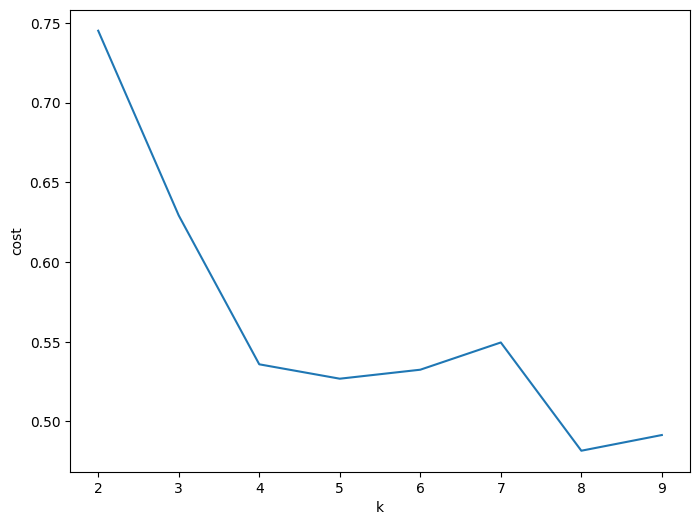

In [14]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

It is very clear that there are two hackers. Let's do the clustering.

In [15]:
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(data_scale_output)
results = model.transform(data_scale_output)

In [16]:
evaluator = ClusteringEvaluator(metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(results)
print("Silhouette = " + str(silhouette))

Silhouette = 0.7880858006977343


In [17]:
model.clusterCenters()

[array([4.00060976e+01, 8.59157866e+02, 5.36585366e-01, 6.92634146e+00,
        1.32134146e+01, 6.57012195e+01, 4.68612195e+01]),
 array([ 20.36470588, 364.22370588,   0.48823529,   3.64952941,
          8.54705882,  64.31764706,  67.45364706])]

In [18]:
model.transform(data_scale_output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  170|
|         0|  164|
+----------+-----+

